# Collective LLM Dynamics: Consensus Formation Experiment with OpenAI API

This notebook reproduces the consensus formation experiment from the paper "コレクティブLLMダイナミクスの数理分析" (Mathematical Analysis of Collective LLM Dynamics) using actual OpenAI LLM agents.

## Experiment Overview
- 100 LLM agents on a toroidal square lattice
- Task: Reach consensus between "Kinoko no Yama" (きのこの山) and "Takenoko no Sato" (たけのこの里)
- Agents interact through pairwise dialogues using OpenAI API
- Initial belief state: 5:5 (neutral)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import random
from typing import List, Tuple, Dict
import seaborn as sns
from scipy.stats import entropy
from collections import defaultdict
import networkx as nx
from IPython.display import display, clear_output
import time
import json
import os
from dataclasses import dataclass, field
import re

# OpenAI imports
import openai
from openai import OpenAI

## OpenAI API Configuration

In [18]:
@dataclass
class OpenAIConfig:
    api_key: str = field(default_factory=lambda: os.getenv("OPENAI_API_KEY", ""))
    model: str = "gpt-4o-mini"
    temperature: float = 0.5
    max_tokens: int = 300

# Initialize OpenAI client
config = OpenAIConfig()
client = OpenAI(api_key=config.api_key)

## LLM Agent Class with OpenAI Integration

In [19]:
class LLMAgent:
    """Represents an LLM agent with belief states about preferences"""
    
    def __init__(self, agent_id: int, initial_belief: float = 0.5, client: OpenAI = None):
        self.id = agent_id
        # Belief represents preference for Kinoko (0) vs Takenoko (1)
        # 0.0 = completely prefer Kinoko, 1.0 = completely prefer Takenoko
        self.belief = initial_belief
        self.position = None
        self.dialogue_history = []
        self.client = client
        self.other_belief_estimate = {}  # Estimates of other agents' beliefs
        
    def get_preference_ratio(self) -> Tuple[int, int]:
        """Convert belief to ratio format (e.g., 3:7)"""
        kinoko = int( (- self.belief) * 10)
        takenoko = int(self.belief * 10)
        return (kinoko, takenoko)
    
    def generate_system_prompt(self) -> str:
        """Generate system prompt based on current belief state"""
        kinoko, takenoko = self.get_preference_ratio()
        
        return f"""あなたは「きのこの山」と「たけのこの里」についての意見を持つエージェントです。
                現在のあなたの好みの比率は、きのこの山:{kinoko}、たけのこの里:{takenoko}です。
                他のエージェントと対話し、お互いの意見を交換してください。
                相手の意見を聞きながら、自分の意見を説明してください。
                対話は自然で友好的に行ってください。"""
    
    def parse_belief_from_response(self, response: str) -> float:
        """Extract belief state from LLM response"""
        # Look for explicit ratio mentions
        ratio_pattern = r'(\d+):(\d+)'
        matches = re.findall(ratio_pattern, response)
        
        if matches:
            # Use the last mentioned ratio
            kinoko, takenoko = map(int, matches[-1])
            total = kinoko + takenoko
            if total > 0:
                return takenoko / total
        
        # Fallback: analyze sentiment
        kinoko_keywords = ['きのこ', 'キノコ', 'kinoko', 'きのこの山が好き', 'きのこ派']
        takenoko_keywords = ['たけのこ', 'タケノコ', 'takenoko', 'たけのこの里が好き', 'たけのこ派']
        
        kinoko_score = sum(1 for keyword in kinoko_keywords if keyword in response.lower())
        takenoko_score = sum(1 for keyword in takenoko_keywords if keyword in response.lower())
        
        # Slight adjustment based on keywords
        if takenoko_score > kinoko_score:
            return min(1.0, self.belief + 0.1)
        elif kinoko_score > takenoko_score:
            return max(-1.0, self.belief - 0.1)
        
        return self.belief
    
    def dialogue_with(self, other: 'LLMAgent', num_exchanges: int = 5):
        """Conduct dialogue with another agent using OpenAI API"""
        if not self.client:
            # Fallback to simulation if no client
            self._simulate_dialogue(other)
            return
        
        conversation_history = []
        
        try:
            # Initial question from self to other
            initial_message = "たけのこ派ですか、きのこ派ですか？"
            conversation_history.append({"role": "user", "content": initial_message})
            
            for exchange in range(num_exchanges):
                # Other agent responds
                other_response = self._get_llm_response(
                    other.generate_system_prompt(),
                    conversation_history,
                    is_other=True
                )
                conversation_history.append({"role": "assistant", "content": other_response})
                
                # Self responds
                if exchange < num_exchanges - 1:
                    self_response = self._get_llm_response(
                        self.generate_system_prompt(),
                        conversation_history,
                        is_other=False
                    )
                    conversation_history.append({"role": "user", "content": self_response})
            
            # Update beliefs based on conversation
            self._update_beliefs_from_conversation(other, conversation_history)
            
            # Record dialogue
            self.dialogue_history.append({
                'partner': other.id,
                'conversation': conversation_history,
                'belief_after': self.belief
            })
            other.dialogue_history.append({
                'partner': self.id,
                'conversation': conversation_history,
                'belief_after': other.belief
            })
            
        except Exception as e:
            print(f"API call failed: {e}. Falling back to simulation.")
            self._simulate_dialogue(other)
    
    def _get_llm_response(self, system_prompt: str, conversation: List[Dict], is_other: bool) -> str:
        """Get response from OpenAI API"""
        messages = [{"role": "system", "content": system_prompt}]
        
        # Add conversation history from the perspective of the current speaker
        for msg in conversation:
            if is_other:
                # Swap roles for the other agent's perspective
                role = "assistant" if msg["role"] == "user" else "user"
            else:
                role = msg["role"]
            messages.append({"role": role, "content": msg["content"]})
        
        response = self.client.chat.completions.create(
            model=config.model,
            messages=messages,
            temperature=config.temperature,
            max_tokens=config.max_tokens
        )
        
        return response.choices[0].message.content
    
    def _update_beliefs_from_conversation(self, other: 'LLMAgent', conversation: List[Dict]):
        """Update beliefs based on the conversation content"""
        # Analyze the entire conversation
        full_text = " ".join([msg["content"] for msg in conversation])
        
        # Update self belief
        new_self_belief = self.parse_belief_from_response(full_text)
        belief_change = new_self_belief - self.belief
        self.belief = self.belief + belief_change * 0.3  # Gradual change
        self.belief = max(-1.0, min(1.0, self.belief))
        
        # Update other's belief (simplified)
        other_belief_change = -belief_change * 0.2
        other.belief = other.belief + other_belief_change
        other.belief = max(-1.0, min(1.0, other.belief))
        
        # Update belief estimates
        self.other_belief_estimate[other.id] = other.belief
        other.other_belief_estimate[self.id] = self.belief
    
    def _simulate_dialogue(self, other: 'LLMAgent'):
        """Fallback simulation when API is not available"""
        belief_diff = abs(self.belief - other.belief)
        influence_factor = 0.1 * belief_diff
        random_factor = random.gauss(0, 0.05)
        
        if self.belief < other.belief:
            self.belief = min(1.0, self.belief + influence_factor + random_factor)
            other.belief = max(-1.0, other.belief - influence_factor * 0.5 + random_factor)
        else:
            self.belief = max(-1.0, self.belief - influence_factor + random_factor)
            other.belief = min(1.0, other.belief + influence_factor * 0.5 + random_factor)
        
        self.dialogue_history.append({
            'partner': other.id,
            'belief_after': self.belief,
            'simulated': True
        })

## Toroidal Square Lattice Implementation

In [20]:
class ToroidalLattice:
    """Represents a toroidal square lattice for agent placement"""
    
    def __init__(self, size: int = 10):
        self.size = size
        self.grid = [[None for _ in range(size)] for _ in range(size)]
        self.agents = []
        
    def add_agent(self, agent: LLMAgent, position: Tuple[int, int]):
        """Place an agent at a specific position"""
        x, y = position
        self.grid[x][y] = agent
        agent.position = position
        self.agents.append(agent)
        
    def get_neighbors(self, position: Tuple[int, int]) -> List[LLMAgent]:
        """Get all neighbors of an agent (von Neumann neighborhood with toroidal wrapping)"""
        x, y = position
        neighbors = []
        
        # Four adjacent cells (up, down, left, right) with toroidal wrapping
        neighbor_positions = [
            ((x - 1) % self.size, y),  # up
            ((x + 1) % self.size, y),  # down
            (x, (y - 1) % self.size),  # left
            (x, (y + 1) % self.size)   # right
        ]
        
        for pos in neighbor_positions:
            agent = self.grid[pos[0]][pos[1]]
            if agent is not None:
                neighbors.append(agent)
                
        return neighbors
    
    def get_random_neighbor_pair(self) -> Tuple[LLMAgent, LLMAgent]:
        """Randomly select a pair of adjacent agents"""
        # Get all possible neighbor pairs
        pairs = []
        for agent in self.agents:
            neighbors = self.get_neighbors(agent.position)
            for neighbor in neighbors:
                # Avoid duplicate pairs
                if (neighbor, agent) not in pairs:
                    pairs.append((agent, neighbor))
        
        return random.choice(pairs) if pairs else (None, None)

## Experiment Setup

In [21]:
def initialize_experiment(num_agents: int = 100, lattice_size: int = 10, use_api: bool = True) -> ToroidalLattice:
    """Initialize the experiment with agents on a toroidal lattice"""
    lattice = ToroidalLattice(lattice_size)
    
    # Create agents with initial neutral belief (0.5)
    agent_id = 0
    for i in range(lattice_size):
        for j in range(lattice_size):
            if agent_id < num_agents:
                agent = LLMAgent(
                    agent_id, 
                    initial_belief=0.5,
                    client=client if use_api else None
                )
                lattice.add_agent(agent, (i, j))
                agent_id += 1
    
    return lattice

def run_stage(lattice: ToroidalLattice, num_dialogues: int = 50, verbose: bool = False):
    """Run one stage of the experiment with random pairwise dialogues"""
    for i in range(num_dialogues):
        agent1, agent2 = lattice.get_random_neighbor_pair()
        if agent1 and agent2:
            if verbose:
                print(f"Dialogue {i+1}/{num_dialogues}: Agent {agent1.id} <-> Agent {agent2.id}")
            agent1.dialogue_with(agent2, num_exchanges=5)
            
            # Add small delay to respect API rate limits
            if agent1.client:
                time.sleep(0.1)

## Visualization Functions

In [22]:
def visualize_belief_states(lattice: ToroidalLattice, stage: int, ax=None):
    """Visualize agent beliefs on the lattice"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Create belief matrix
    belief_matrix = np.zeros((lattice.size, lattice.size))
    for i in range(lattice.size):
        for j in range(lattice.size):
            if lattice.grid[i][j] is not None:
                belief_matrix[i][j] = lattice.grid[i][j].belief
            else:
                belief_matrix[i][j] = 0.5
    
    # Create custom colormap (blue for Kinoko, red for Takenoko)
    colors = ['blue', 'white', 'red']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('kinoko_takenoko', colors, N=n_bins)
    
    # Plot
    im = ax.imshow(belief_matrix, cmap=cmap, vmin=0, vmax=1, interpolation='nearest')
    ax.set_title(f'Stage {stage}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(True, color='gray', linewidth=0.5)
    
    # Add grid lines
    for i in range(lattice.size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5)
    
    return im

def calculate_metrics(lattice: ToroidalLattice) -> Dict:
    """Calculate various metrics for the current state"""
    beliefs = [agent.belief for agent in lattice.agents]
    
    # Calculate entropy
    hist, _ = np.histogram(beliefs, bins=10, range=(0, 1))
    hist = hist + 1e-10  # Avoid log(0)
    belief_entropy = entropy(hist / hist.sum())
    
    # Calculate KL divergence between neighbors
    kl_sum = 0
    pair_count = 0
    for agent in lattice.agents:
        neighbors = lattice.get_neighbors(agent.position)
        for neighbor in neighbors:
            # Simple KL approximation
            kl = abs(agent.belief - neighbor.belief)
            kl_sum += kl
            pair_count += 1
    
    kl_divergence = kl_sum / pair_count if pair_count > 0 else 0
    
    # Count agents by preference category
    kinoko_agents = sum(1 for b in beliefs if b < 0.33)
    neutral_agents = sum(1 for b in beliefs if 0.33 <= b <= 0.67)
    takenoko_agents = sum(1 for b in beliefs if b > 0.67)
    
    # Find largest cluster (simplified)
    clusters = find_clusters(lattice)
    max_cluster_size = max(len(cluster) for cluster in clusters) if clusters else 0
    
    # Calculate belief estimation error
    estimation_error = 0
    error_count = 0
    for agent in lattice.agents:
        for other_id, estimated_belief in agent.other_belief_estimate.items():
            actual_agent = next((a for a in lattice.agents if a.id == other_id), None)
            if actual_agent:
                estimation_error += abs(estimated_belief - actual_agent.belief)
                error_count += 1
    
    avg_estimation_error = estimation_error / error_count if error_count > 0 else 0
    
    return {
        'entropy': belief_entropy,
        'kl_divergence': kl_divergence,
        'kinoko_count': kinoko_agents,
        'neutral_count': neutral_agents,
        'takenoko_count': takenoko_agents,
        'max_cluster_size': max_cluster_size,
        'estimation_error': avg_estimation_error
    }

def find_clusters(lattice: ToroidalLattice, threshold: float = 0.2) -> List[List[LLMAgent]]:
    """Find clusters of agents with similar beliefs"""
    visited = set()
    clusters = []
    
    def dfs(agent: LLMAgent, cluster: List[LLMAgent], target_belief: float):
        if agent.id in visited:
            return
        if abs(agent.belief - target_belief) > threshold:
            return
        
        visited.add(agent.id)
        cluster.append(agent)
        
        neighbors = lattice.get_neighbors(agent.position)
        for neighbor in neighbors:
            dfs(neighbor, cluster, target_belief)
    
    for agent in lattice.agents:
        if agent.id not in visited:
            cluster = []
            dfs(agent, cluster, agent.belief)
            if cluster:
                clusters.append(cluster)
    
    return clusters

## Run the Experiment

In [23]:
# Configuration
USE_OPENAI_API = True  # Set to False to use simulation only
# NUM_AGENTS = 100  # Total number of agents
# LATTICE_SIZE = 10  # 10x10 grid
# NUM_STAGES = 32  # Number of stages as per paper
# DIALOGUES_PER_STAGE = 25  # Number of dialogues per stage
NUM_AGENTS = 25  # Total number of agents
LATTICE_SIZE = 5  # 10x10 grid
NUM_STAGES = 32  # Number of stages as per paper
DIALOGUES_PER_STAGE = 25  # Number of dialogues per stage

# For testing with API, you might want to use fewer agents/stages
if USE_OPENAI_API:
    print("WARNING: Using OpenAI API will make many API calls. Consider using fewer agents/stages for testing.")
    print("Current settings will make approximately", NUM_STAGES * DIALOGUES_PER_STAGE * NUM_AGENTS, "API calls.")

Current settings will make approximately 20000 API calls.


In [ ]:
# Initialize experiment
print("Initializing experiment...")
lattice = initialize_experiment(
    num_agents=NUM_AGENTS, 
    lattice_size=LATTICE_SIZE,
    use_api=USE_OPENAI_API
)

# Track metrics over time
metrics_history = {
    'entropy': [],
    'kl_divergence': [],
    'kinoko_count': [],
    'neutral_count': [],
    'takenoko_count': [],
    'max_cluster_size': [],
    'estimation_error': []
}

# Create figure for visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Stages to visualize (as per paper)
visualization_stages = [1, 5, 10, 15, 20, 25, 30]
vis_index = 0

# Run experiment
print(f"Running {NUM_STAGES} stages...")
for stage in range(NUM_STAGES + 1):
    print(f"\nStage {stage}/{NUM_STAGES}")
    
    # Calculate metrics
    metrics = calculate_metrics(lattice)
    for key, value in metrics.items():
        metrics_history[key].append(value)
    
    # Print current state
    print(f"  Kinoko: {metrics['kinoko_count']}, Neutral: {metrics['neutral_count']}, Takenoko: {metrics['takenoko_count']}")
    print(f"  Entropy: {metrics['entropy']:.3f}, KL Divergence: {metrics['kl_divergence']:.3f}")
    
    # Visualize at specific stages
    if stage in visualization_stages and vis_index < 8:
        ax = fig.add_subplot(gs[vis_index // 4, vis_index % 4])
        visualize_belief_states(lattice, stage, ax)
        vis_index += 1
    
    # Run dialogues for next stage
    if stage < NUM_STAGES:
        run_stage(lattice, num_dialogues=DIALOGUES_PER_STAGE, verbose=False)

plt.suptitle('Agent Belief States Evolution (Blue=Kinoko, Red=Takenoko)', fontsize=16)
plt.tight_layout()
plt.show()

Initializing experiment...
Running 32 stages...

Stage 0/32
  Kinoko: 0, Neutral: 25, Takenoko: 0
  Entropy: 0.000, KL Divergence: 0.000


## Plot Metrics Over Time

/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_38914/3087985907.py:68: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_38914/3087985907.py:68: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_38914/3087985907.py:68: UserWarning: Glyph 24565 (\N{CJK UNIFIED IDEOGRAPH-5FF5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_38914/3087985907.py:68: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_38914/3087985907.py:68: UserWarning: Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/vxvh

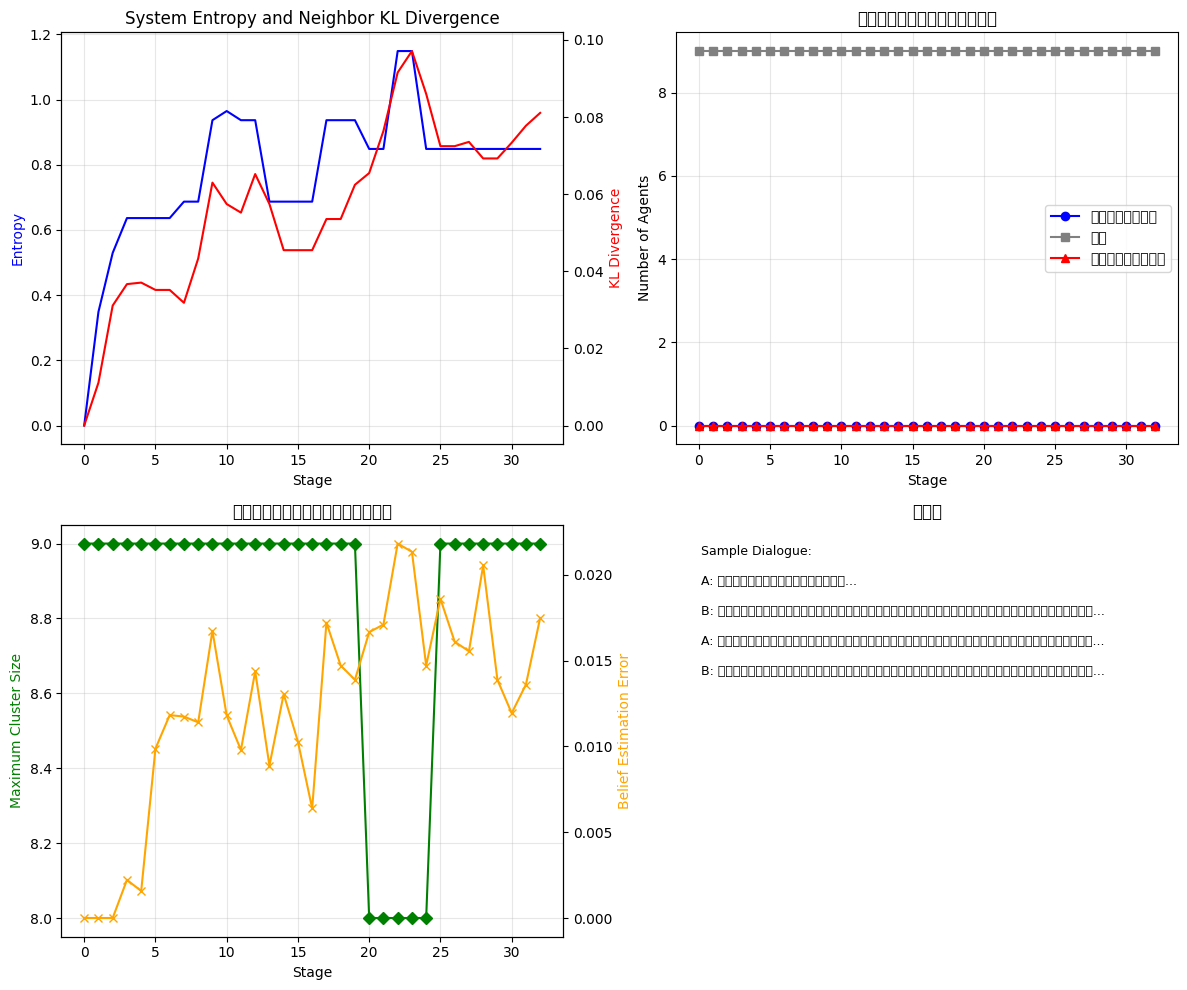

In [37]:
# Create metrics plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Entropy and KL Divergence
ax1 = axes[0, 0]
ax1.plot(metrics_history['entropy'], label='Entropy', color='blue')
ax1_twin = ax1.twinx()
ax1_twin.plot(metrics_history['kl_divergence'], label='KL Divergence', color='red')
ax1.set_xlabel('Stage')
ax1.set_ylabel('Entropy', color='blue')
ax1_twin.set_ylabel('KL Divergence', color='red')
ax1.set_title('System Entropy and Neighbor KL Divergence')
ax1.grid(True, alpha=0.3)

# Plot 2: Agent Counts by Category
ax2 = axes[0, 1]
stages = list(range(len(metrics_history['kinoko_count'])))
ax2.plot(stages, metrics_history['kinoko_count'], label='Kinoko', color='blue', marker='o')
ax2.plot(stages, metrics_history['neutral_count'], label='Neutral', color='gray', marker='s')
ax2.plot(stages, metrics_history['takenoko_count'], label='Takenoko', color='red', marker='^')
ax2.set_xlabel('Stage')
ax2.set_ylabel('Number of Agents')
ax2.set_title('Belief Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Maximum Cluster Size and Estimation Error
ax3 = axes[1, 0]
ax3.plot(metrics_history['max_cluster_size'], color='green', marker='D', label='Max Cluster Size')
ax3_twin = ax3.twinx()
ax3_twin.plot(metrics_history['estimation_error'], color='orange', marker='x', label='Estimation Error')
ax3.set_xlabel('Stage')
ax3.set_ylabel('Maximum Cluster Size', color='green')
ax3_twin.set_ylabel('Belief Estimation Error', color='orange')
ax3.set_title('Maximum Cluster Size and Belief Estimation Error')
ax3.grid(True, alpha=0.3)

# Plot 4: Sample Dialogue (if using API)
ax4 = axes[1, 1]
if USE_OPENAI_API and lattice.agents[0].dialogue_history:
    # Show a sample dialogue
    sample_dialogue = None
    for agent in lattice.agents:
        if agent.dialogue_history and 'conversation' in agent.dialogue_history[-1]:
            sample_dialogue = agent.dialogue_history[-1]['conversation']
            break
    
    if sample_dialogue:
        dialogue_text = "Sample Dialogue:\n\n"
        for i, msg in enumerate(sample_dialogue[:4]):  # Show first 4 exchanges
            role = "A" if msg['role'] == 'user' else "B"
            dialogue_text += f"{role}: {msg['content'][:50]}...\n\n"
        ax4.text(0.05, 0.95, dialogue_text, transform=ax4.transAxes, 
                fontsize=9, verticalalignment='top', wrap=True)
        ax4.set_title('Sample Dialogue')
        ax4.axis('off')
else:
    # Show final belief distribution
    final_beliefs = [agent.belief for agent in lattice.agents]
    ax4.hist(final_beliefs, bins=20, alpha=0.7, color='purple', edgecolor='black')
    ax4.set_xlabel('Belief Value')
    ax4.set_ylabel('Number of Agents')
    ax4.set_title('Final Belief Distribution')
    ax4.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Neutral (0.5)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analysis Summary

In [38]:
# Print summary statistics
print("実験結果の要約")
print("=" * 50)
print(f"総ステージ数: {NUM_STAGES}")
print(f"エージェント総数: {len(lattice.agents)}")
print(f"API使用: {'はい' if USE_OPENAI_API else 'いいえ (シミュレーション)'}")
print(f"\n最終状態:")
print(f"  きのこの山支持者: {metrics_history['kinoko_count'][-1]}")
print(f"  中立的エージェント: {metrics_history['neutral_count'][-1]}")
print(f"  たけのこの里支持者: {metrics_history['takenoko_count'][-1]}")
print(f"  最大クラスタサイズ: {metrics_history['max_cluster_size'][-1]}")
print(f"\nシステムメトリクス:")
print(f"  初期エントロピー: {metrics_history['entropy'][0]:.4f}")
print(f"  最終エントロピー: {metrics_history['entropy'][-1]:.4f}")
print(f"  初期KL divergence: {metrics_history['kl_divergence'][0]:.4f}")
print(f"  最終KL divergence: {metrics_history['kl_divergence'][-1]:.4f}")
print(f"  平均信念推定誤差: {metrics_history['estimation_error'][-1]:.4f}")

# Check for consensus
if metrics_history['kinoko_count'][-1] > 90:
    print("\n合意形成達成: きのこの山！")
elif metrics_history['takenoko_count'][-1] > 90:
    print("\n合意形成達成: たけのこの里！")
else:
    print("\n明確な合意形成には至りませんでした。")

# Save results
results = {
    'config': {
        'num_agents': NUM_AGENTS,
        'lattice_size': LATTICE_SIZE,
        'num_stages': NUM_STAGES,
        'dialogues_per_stage': DIALOGUES_PER_STAGE,
        'use_api': USE_OPENAI_API
    },
    'metrics_history': metrics_history,
    'final_beliefs': [agent.belief for agent in lattice.agents]
}

# Save to JSON file
with open('llm_consensus_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)
print("\n結果をllm_consensus_results.jsonに保存しました。")

実験結果の要約
総ステージ数: 32
エージェント総数: 9
API使用: はい

最終状態:
  きのこの山支持者: 0
  中立的エージェント: 9
  たけのこの里支持者: 0
  最大クラスタサイズ: 9

システムメトリクス:
  初期エントロピー: 0.0000
  最終エントロピー: 0.8487
  初期KL divergence: 0.0000
  最終KL divergence: 0.0811
  平均信念推定誤差: 0.0175

明確な合意形成には至りませんでした。

結果をllm_consensus_results.jsonに保存しました。
